In [1]:
import numpy as np
import netCDF4
import subprocess
from operator import itemgetter
import gsw
from matplotlib import pyplot as plt

# read the database of argo profile data as set up
cur_dir = subprocess.check_output("pwd", shell=True)[:-1]
dest_dir = cur_dir + "/jerupiga/"
dbase = np.load(dest_dir + "argo_profile_info_database.npz")["dbase"]

In [2]:
print len(dbase)
match = dbase[dbase["ps_qc"] != 'F']
print len(match)
match = match[match["ps_qc"] != 'E']
print len(match)
match = match[match["ps_qc"] != 'D']
print len(match), len(match[np.logical_or(match["pt_qc"] == 'E', match["pt_qc"] == 'F')]), len(match[match["pt_qc"]=="F"])
# match = match[np.logical_or(match["pt_qc"] != 'F', match["pt_qc"] != 'E')]
match = match[match["pt_qc"] != 'F']
print len(match), len(match[np.logical_or(match["pt_qc"] == 'D', match["pp_qc"] == 'F')]), len(match[match["pp_qc"]=="E"])
# match = dbase[np.logical_and(dbase["lon"] >= 75., dbase["lon"] <= 85.)]
match = match[np.logical_and(match["lon"] >= 78.5, match["lon"] <= 82.5)]
match = match[np.logical_and(match["lat"] <= -6.5, match["lat"] >= -9.5)]
# match = match[np.logical_or(match["month"] <= 4, match["month"] >= 11)]
print len(match)
match = match[np.logical_and(match["pmin"] <= 50., match["pmax"] >= 200.)]
# match = match[np.logical_or(match["pt_qc"] != "D", match["ps_qc"] != "D")]
print len(match)

17486
15897
15886
15881 2 2
15879 0 0
437
437


/home/saulo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater_equal
/home/saulo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less_equal


In [3]:
daids = list(set(match["floatid"]))  # has to be same as filestoread, could come before pathstofile
pathstofiles = [dest_dir + m + "_prof.nc" for m in daids]

In [4]:
def with_common_mask(*args):
    mask = np.ma.getmask(args[0])
    for arg in args[1:]:
        mask = np.ma.mask_or(mask, np.ma.getmask(arg))
    out = []
    for arg in args:
        out.append(np.ma.array(arg, mask=mask, keep_mask=False))
    return out

def fillup_argolist():
    argo_profs = []
    append = argo_profs.append
    MA = np.ma.masked_invalid
    for n in range(0, len(daids)):
        argo_data = netCDF4.Dataset(pathstofiles[n])
        #  argo_data = netCDF4.Dataset(filestoread[n])
        prof_idxs = match[match["floatid"]==daids[n]]["prof_n"]
        # start pulling off data, should go all into some container class type (which would have limited functionality):
        juld = argo_data.variables['JULD'][prof_idxs]  # at the moment contains multiple profiles
        juld_qc = argo_data.variables['JULD_QC'][prof_idxs]
        juld_loc = argo_data.variables['JULD_LOCATION'][prof_idxs]
        lat = argo_data.variables['LATITUDE'][prof_idxs]
        lon = argo_data.variables['LONGITUDE'][prof_idxs]
        pos_qc = argo_data.variables['POSITION_QC'][prof_idxs]
        prof_pres_qc = argo_data.variables['PROFILE_PRES_QC'][prof_idxs]
        prof_sal_qc = argo_data.variables['PROFILE_PSAL_QC'][prof_idxs]
        prof_temp_qc = argo_data.variables['PROFILE_TEMP_QC'][prof_idxs]
        pres = argo_data.variables['PRES'][prof_idxs, :]
        pres_qc = argo_data.variables['PRES_QC'][prof_idxs, :]
        pres_a = argo_data.variables['PRES_ADJUSTED'][prof_idxs, :]
        pres_a_qc = argo_data.variables['PRES_ADJUSTED_QC'][prof_idxs, :]
        pres_a_er = argo_data.variables['PRES_ADJUSTED_ERROR'][prof_idxs, :]
        sal = argo_data.variables['PSAL'][prof_idxs, :]
        sal_qc = argo_data.variables['PSAL_QC'][prof_idxs, :]
        sal_a = argo_data.variables['PSAL_ADJUSTED'][prof_idxs, :]
        sal_a_qc = argo_data.variables['PSAL_ADJUSTED_QC'][prof_idxs, :]
        sal_a_er = argo_data.variables['PSAL_ADJUSTED_ERROR'][prof_idxs, :]
        temp = argo_data.variables['TEMP'][prof_idxs, :]
        temp_qc = argo_data.variables['TEMP_QC'][prof_idxs, :]
        temp_a = argo_data.variables['TEMP_ADJUSTED'][prof_idxs, :]
        temp_a_qc = argo_data.variables['TEMP_ADJUSTED_QC'][prof_idxs, :]
        temp_a_er = argo_data.variables['TEMP_ADJUSTED_ERROR'][prof_idxs, :]
        min_p = pres.min(axis=-1)
        max_p = pres.max(axis=-1)
        argo_data.close()
        
        # need to enforce masks between pressure, temp and sal are consistent (masking if any P,S,T element is):
        pres, temp, sal = with_common_mask(pres, temp, sal)
        pres_a, temp_a, sal_a = with_common_mask(pres_a, temp_a, sal_a)
        pres_a_er, temp_a_er, sal_a_er = with_common_mask(pres_a_er, temp_a_er, sal_a_er)
        
        # storing these data in arrays or lists? something that will allow easy further querying and sorting
        for k in range(0, len(prof_idxs)):
            # derived variables from delayed mode so far:
            SA = MA(gsw.SA_from_SP(sal_a[k], pres_a[k], lon[k], lat[k]))
            CT = gsw.CT_from_t(SA, temp_a[k], pres_a[k])
            Theta = gsw.pt0_from_t(SA, temp_a[k], pres_a[k])
            Nsq, p_mid, Nsq_b, Nsq_a = gsw.Nsquared(SA, CT, pres_a[k], lat[k]) # needs remasking
            sig_theta = gsw.rho(SA, CT, 0) # potential density referenced to 0, using one scheme 
            #sig_theta_2 = gsw.sigma0_pt0_exact(SA, Theta) # potential density ref to 0db but using Theta, slightly different
            #rho, Alpha, Beta = gsw.rho_alpha_beta(SA, CT, pres)
            
#            append([juld[k], lat[k], lon[k], juld_qc[k], pos_qc[k], min_p[k], max_p[k],
#                    prof_pres_qc[k], prof_sal_qc[k], prof_temp_qc[k], MA(pres[k]), pres_qc[k],
#                    MA(pres_a[k]), pres_a_qc[k], MA(pres_a_er[k]), MA(sal[k]), sal_qc[k], MA(sal_a[k]),
#                    sal_a_qc[k], MA(sal_a_er[k]), MA(temp[k]), temp_qc[k], MA(temp_a[k]), temp_a_qc[k],
#                    MA(temp_a_er[k]), MA(SA), MA(CT), MA(Theta), MA(sig_theta), MA(Nsq), MA(Nsq_b), MA(Nsq_a), MA(p_mid)])  # is a list of profiles, in fact a list of a list of prof properties
            append([juld[k], lat[k], lon[k], juld_qc[k], pos_qc[k], min_p[k], max_p[k],
                    prof_pres_qc[k], prof_sal_qc[k], prof_temp_qc[k], pres[k], pres_qc[k],
                    pres_a[k], pres_a_qc[k], pres_a_er[k], sal[k], sal_qc[k], sal_a[k],
                    sal_a_qc[k], sal_a_er[k], temp[k], temp_qc[k], temp_a[k], temp_a_qc[k],
                    temp_a_er[k], SA, CT, Theta, sig_theta, Nsq, Nsq_b, Nsq_a, p_mid])  # is a list of profiles, in fact a list of a list of prof properties
    return argo_profs
argo_profs = fillup_argolist()

In [ ]:
# argo_profiles_time = sorted(argo_profs, key=itemgetter(0))  # sort list by time

In [5]:
N2, pmid = argo_profs[0][-4], argo_profs[0][-1]
pmin = zip(*argo_profs)[5]
pmax = zip(*argo_profs)[6]
ppqc = zip(*argo_profs)[7]
lats = zip(*argo_profs)[1]
lons = zip(*argo_profs)[2]

from matplotlib.dates import datestr2num, num2date
ref_date_num = datestr2num("1950-01-01") 
juld = map(ref_date_num .__add__, zip(*argo_profs)[0])

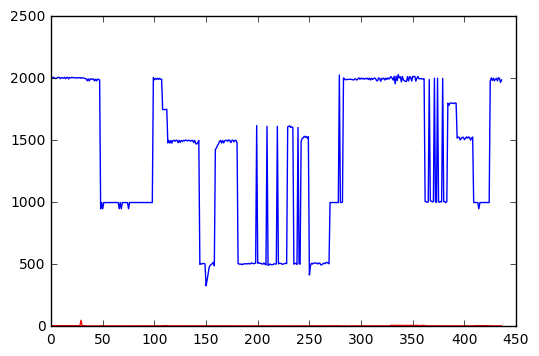

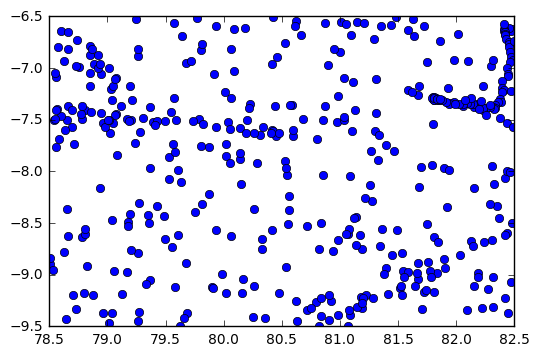

-7.592 80.838


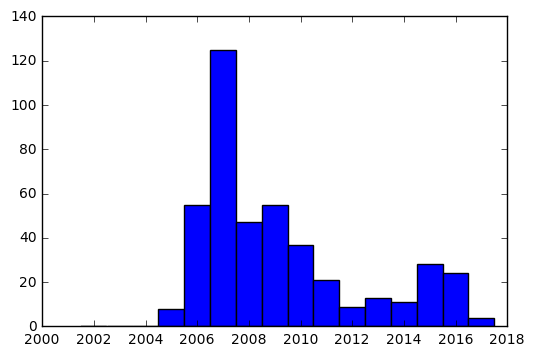

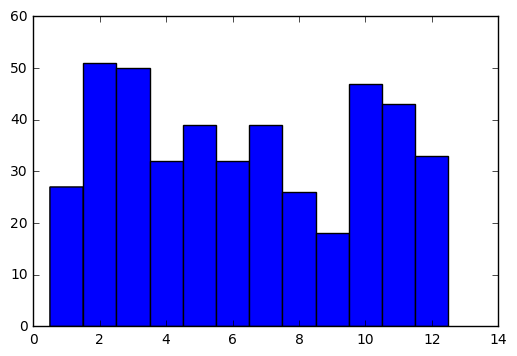

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
#plt.figure()
#plt.plot(N2,-pmid)
#plt.show()
#print np.min(N2)
plt.figure()
plt.plot(pmax, 'b')
plt.plot(pmin, 'r')
plt.show()
plt.figure()
plt.plot(lons, lats, 'o')
plt.show()
print np.median(lats), np.median(lons)
plt.figure()
plt.hist(map(lambda x:x.year, num2date(juld)), bins=np.arange(2002, 2019), align="left")
plt.show()
plt.figure()
plt.hist(map(lambda x:x.month, num2date(juld)), bins=np.arange(1,14), align="left")
plt.show()
# juld[map(lambda x:x.month, num2date(juld)) == 12]
# plt.figure(), plt.plot(map(lambda x:x.month, num2date(juld))), plt.show()

In [7]:
months = np.array(np.array(map(lambda x:x.month, num2date(juld))))
years = np.array(map(lambda x:x.year, num2date(juld)))

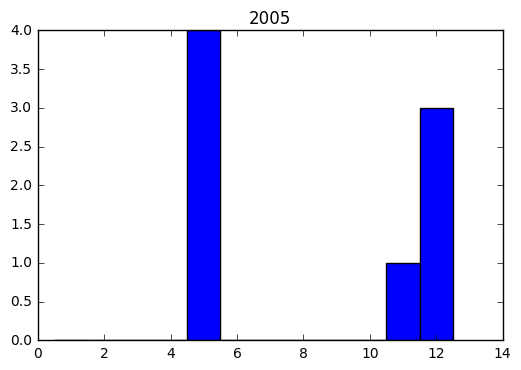

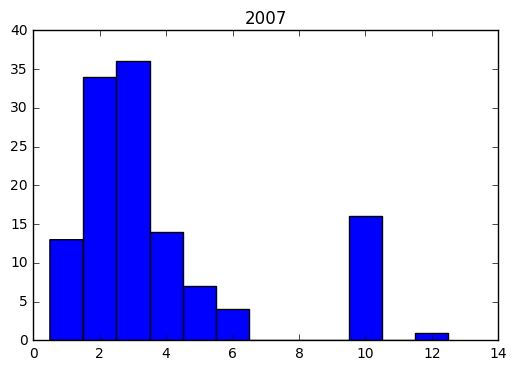

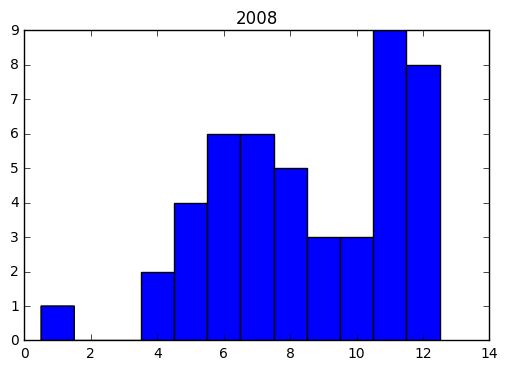

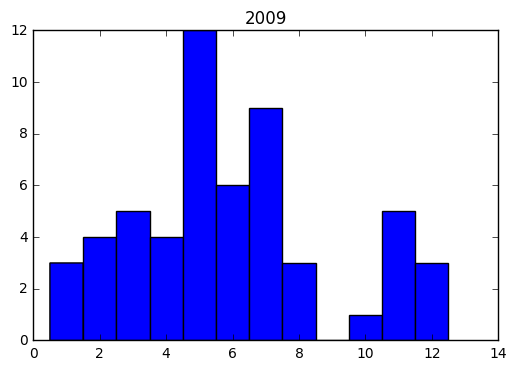

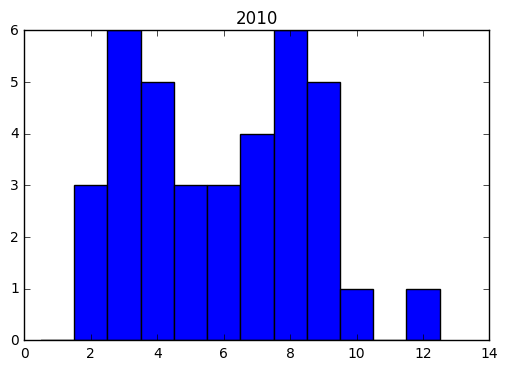

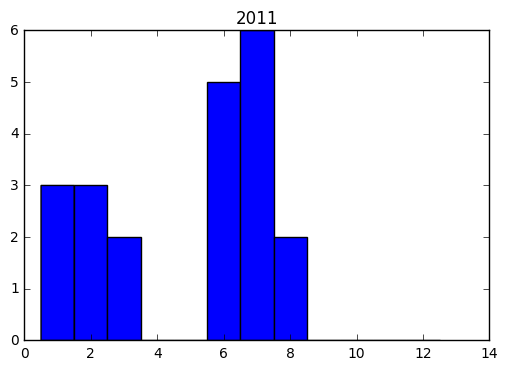

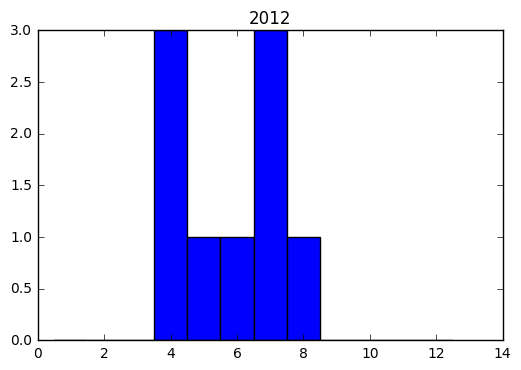

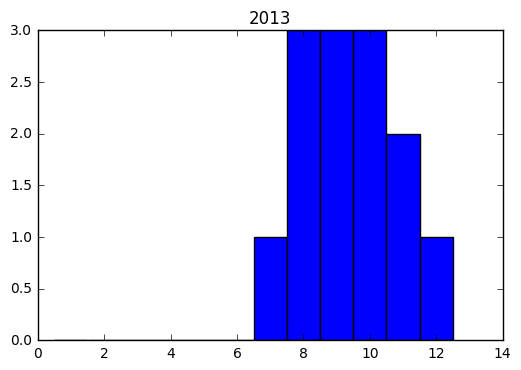

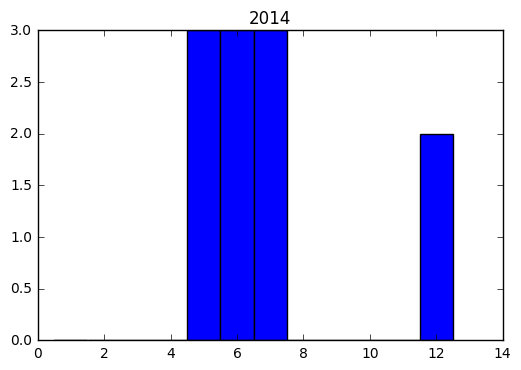

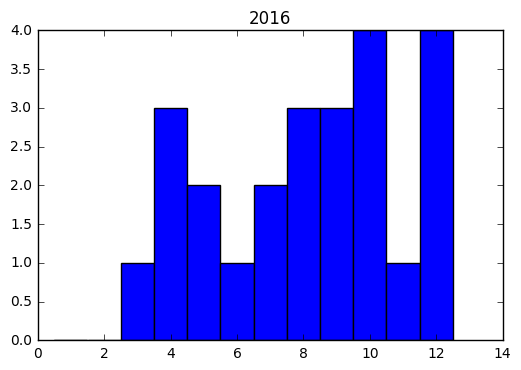

In [8]:
plt.figure()
plt.hist(months[years == 2005], bins=np.arange(1,14), align="left")
plt.title("2005")
plt.figure()
plt.hist(months[years == 2007], bins=np.arange(1,14), align="left")
plt.title("2007")
plt.figure()
plt.hist(months[years == 2008], bins=np.arange(1,14), align="left")
plt.title("2008")
plt.figure()
plt.hist(months[years == 2009], bins=np.arange(1,14), align="left")
plt.title("2009")
plt.figure()
plt.hist(months[years == 2010], bins=np.arange(1,14), align="left")
#print months[years == 2010], len(months[years == 2010])
plt.title("2010")
plt.figure()
plt.hist(months[years == 2011], bins=np.arange(1,14), align="left")
plt.title("2011")
plt.figure()
plt.hist(months[years == 2012], bins=np.arange(1,14), align="left")
plt.title("2012")
plt.figure()
plt.hist(months[years == 2013], bins=np.arange(1,14), align="left")
plt.title("2013")
plt.figure()
plt.hist(months[years == 2014], bins=np.arange(1,14), align="left")
plt.title("2014")
plt.figure()
plt.hist(months[years == 2016], bins=np.arange(1,14), align="left")
plt.title("2016")

(0, 150)

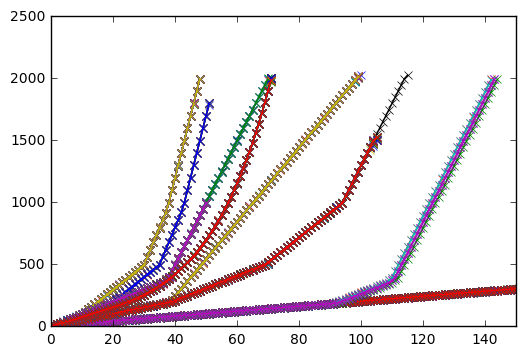

In [9]:
# need area average at every month of every year (time data)
# to do that (ALL) profiles need to be interpolated to a common vertical grid
# determine the vertical grid based typical pressure profile
pres = zip(*argo_profs)[12]
plt.figure()
dz = []
for n in range(len(pres)):
    plt.plot(pres[n], '-x')
    dz.append(np.gradient(pres[n]))
plt.xlim([0, 150])

(0, 150)

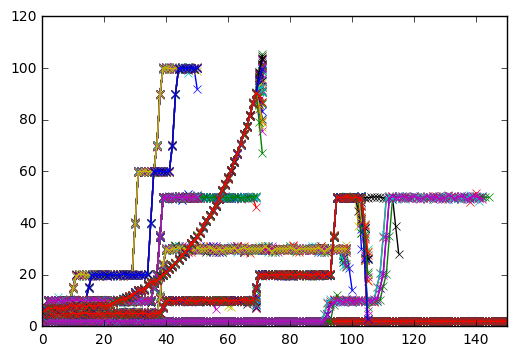

In [10]:
plt.figure()
for n in range(len(pres)):
    plt.plot(dz[n], '-x')
plt.xlim([0, 150])

In [11]:
DZ = [x.tolist() for x in dz]
P = [x.tolist() for x in pres]
DZ = [item for sublist in dz for item in sublist if item is not None or item is not nan]
P = [item for sublist in pres for item in sublist if item is not None]
#import itertools
#DZ = list(itertools.chain.from_iterable(DZ)) 
#P = list(itertools.chain.from_iterable(P))
DZ = np.asanyarray(DZ)
P = np.asanyarray(P)
#print orca[np.isnan(orca) is False].min()
DZ = np.ma.masked_where(np.isnan(DZ), DZ)
P = np.ma.masked_where(np.isnan(P), P)

/home/saulo/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


0.299926757812 105.300048828 1.89999997616 2031.0
(108622,) (108622,)


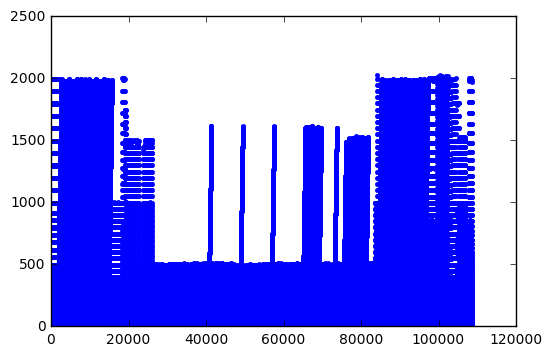

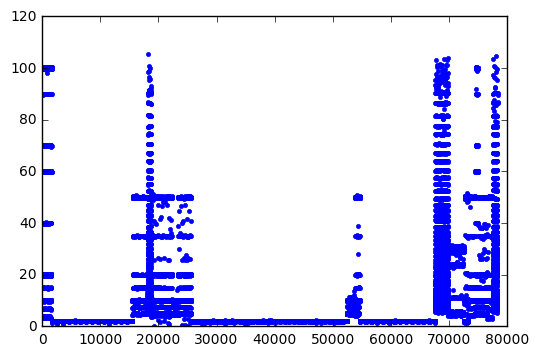

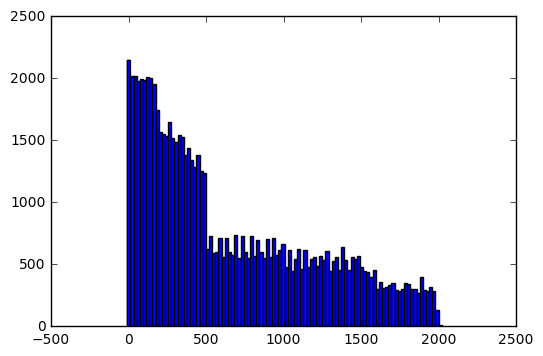

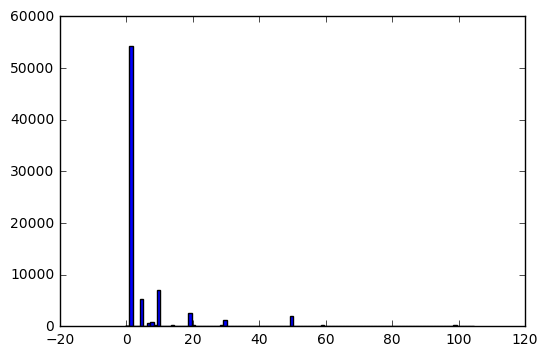

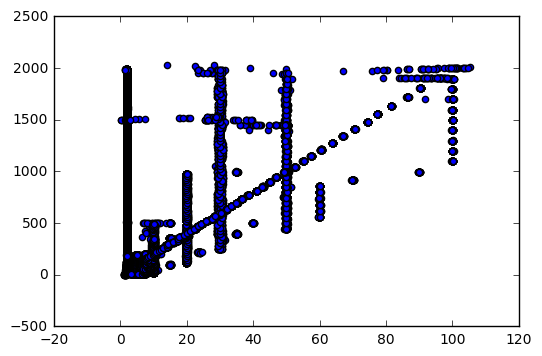

In [12]:
print DZ.min(), DZ.max(), P.min(), P.max()
print P.shape, DZ.shape

plt.figure()
plt.plot(P, '.')
plt.figure()
plt.plot(DZ.compressed(), '.')
plt.figure()
plt.hist(P.compressed(), bins=100, align="left")
plt.figure()
plt.hist(DZ.compressed(), bins=100, align="left")
plt.figure()
plt.scatter(DZ, P)

In [ ]:
# just to learn/test some list of list operations (merge)
#xupa = [item for sublist in dz for item in sublist] # [leaf for tree in forest for leaf in tree] 
#import operator
#xupa2 = reduce(operator.concat, DZ)
#import itertools
#xupa3 = list(itertools.chain.from_iterable(DZ)) 

ModeResult(mode=array([ 2.]), count=array([49941]))
2.0
7.60684856828
105.300048828
21664
21663


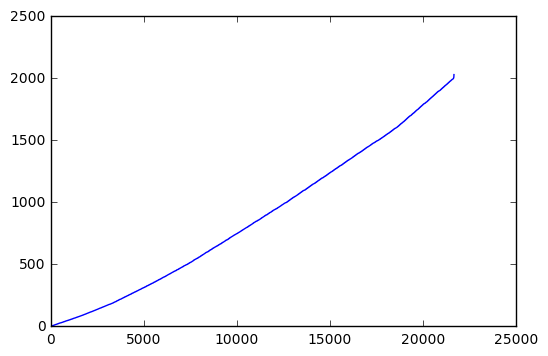

In [13]:
from scipy import stats
print stats.mode(DZ.compressed())
print np.median(DZ.compressed())
print np.mean(DZ.compressed())
print np.max(DZ.compressed())
print len(np.ma.unique(P))
print len(set(P.compressed()))
plt.figure
plt.plot(np.ma.unique(P))
#plt.plot(list(set(P.compressed())))
#print list(set(P.compressed()))

In [14]:
# a new pressure grid:
pnew_min, pnew_dz, pnew_ml, pnew_dz_tc, pnew_tc = 2., 2., 50., 5., 200.
pnew_dz_dtc, pnew_, pnew_dz_mt, pnew_tc = 10., 500, 5., 200.

pnew = np.concatenate((np.arange(2., 52., 2.), np.arange(55., 205., 5.), np.arange(210.,510.,10.),
                      np.arange(510., 1025., 25.), np.arange(1050., 2050., 50)))
# or loop through the unique/set of pressure values (which capture most) then perform the spatial and/or time averages?

437
ModeResult(mode=array([72], dtype=int32), count=array([94]))
79.0
248.562929062


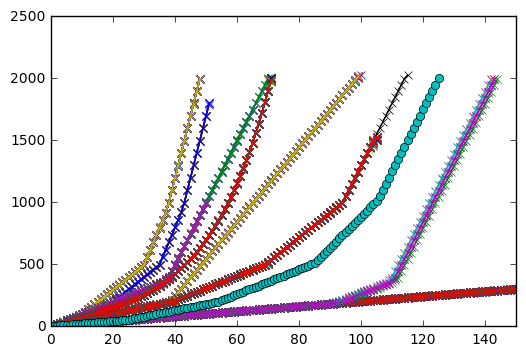

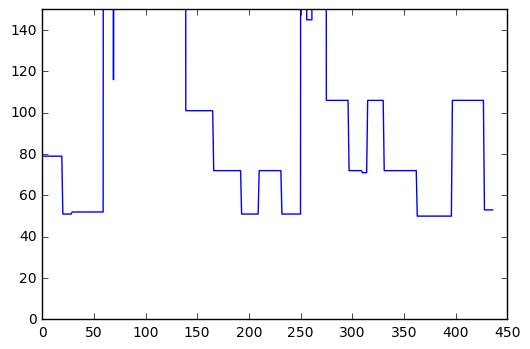

In [15]:
plt.figure()
for n in range(len(pres)):
    plt.plot(pres[n], '-x')
plt.plot(pnew, '-o', lw=2)
plt.xlim([0, 150])
print len(match)
plt.figure()
plt.plot(match["nlevs"])
plt.ylim([0, 150])
print stats.mode(match["nlevs"])
print np.median(match["nlevs"])
print np.mean(match["nlevs"])

The new pressure coord is less than ideal; too much resolution than what is typically apparent, lets see what the data suggest as the most common pressure distribution.

We learned above that the most frequent number of pressure levels (nlevs) is 72. Now let's see how those cover the 2000 db domain.

In [16]:
#suckit = match["nlevs"] # using match database is useless since we are now using the argo_prof list
suckit = [len(x) for x in pres]
print len(suckit)
print min(suckit), max(suckit)
suckit = np.array(suckit)
print suckit[suckit==72] # also stay with only if profile sampled to 2000
print len(suckit[suckit==72])
print np.where(suckit == 72)
#print len(np.where(match["nlevs"]==72)[0]) # this is wrong
#nega = np.where(match["nlevs"]==72)[0]
print len(np.where(suckit==72)[0])
nega = np.where(suckit==72)[0] # need this because tuple of pressure profiles only take integer index
nega.shape
print suckit[nega]
dpmax = np.zeros_like(suckit[nega])
for n in range(len(nega)):
    dpmax[n] = pres[nega[n]].max()
print dpmax
print nega[dpmax>=1900]

437
50 1000
[72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72
 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72
 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72
 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72]
94
(array([ 99, 100, 101, 102, 103, 104, 105, 106, 107, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 280, 281,
       282, 283, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307,
       308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320,
       321, 322, 323, 324, 325, 326, 327, 328, 362, 363, 364, 365, 366,
       367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379,
       380, 381, 382, 383, 425, 426, 427, 428, 429, 430, 431, 432, 433,
       434, 435, 436]),)
94
[72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72
 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72
 72 72 72 72 

5.3 92.0
5.9 105.3


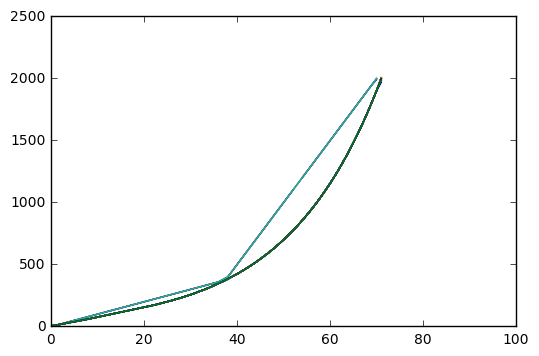

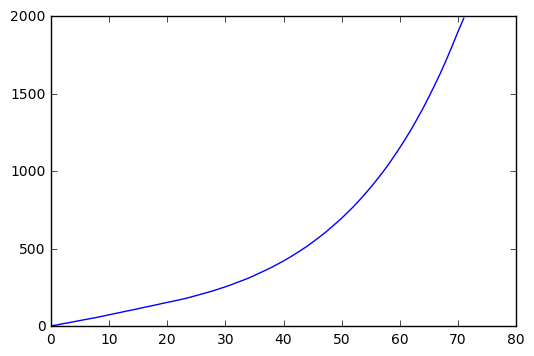

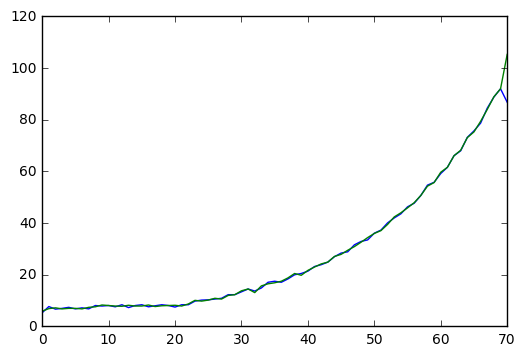

In [17]:
plt.figure()
for n in nega[dpmax>=1900]:
    plt.plot(pres[n])
    # print n, len(pres[n]) # was for debugging
plt.xlim([0, 100])
plt.figure()
plt.plot(pres[nega[dpmax>=1900][-1]])
plt.figure()
plt.plot(np.diff(pres[nega[dpmax>=1900][-1]]))
plt.plot(np.diff(pres[nega[dpmax>=1900][0]]))
print np.min(np.diff(pres[nega[dpmax>=1900][-1]])), np.max(np.diff(pres[nega[dpmax>=1900][-1]]))
print np.min(np.diff(pres[nega[dpmax>=1900][0]])), np.max(np.diff(pres[nega[dpmax>=1900][0]]))

The green/red curve is a coarser version of the initial new pressure coordinate.

Something like the blue curves look very generic. Let's use that to regrid all profiles (of the quantities of interest).

In [18]:
# pnew = pres[nega[dpmax>=1900][-1]]  # later compare with pnew of higher resolution
def argo_prof_regrid(pnew):
    S = np.empty((len(argo_profs), len(pnew)))
    T = np.empty((len(argo_profs), len(pnew)))
    SA = np.empty((len(argo_profs), len(pnew)))
    CT = np.empty((len(argo_profs), len(pnew)))
    Theta = np.empty((len(argo_profs), len(pnew)))
    sig_theta = np.empty((len(argo_profs), len(pnew)))
    Nsq = np.empty((len(argo_profs), len(pnew)))
    Nsq_beta = np.empty((len(argo_profs), len(pnew)))
    Nsq_alpha = np.empty((len(argo_profs), len(pnew)))
    for n in range(0, len(argo_profs)):
        # print n
        S[n, :] = np.interp(pnew, argo_profs[n][12].compressed(), argo_profs[n][17].compressed(), left=np.nan, right=np.nan)
        T[n, :] = np.interp(pnew, argo_profs[n][12].compressed(), argo_profs[n][22].compressed(), left=np.nan, right=np.nan)
        SA[n, :] = np.interp(pnew, argo_profs[n][12].compressed(), argo_profs[n][25].compressed(), left=np.nan, right=np.nan)
        CT[n, :] = np.interp(pnew, argo_profs[n][12].compressed(), argo_profs[n][26].compressed(), left=np.nan, right=np.nan)
        Theta[n, :] = np.interp(pnew, argo_profs[n][12].compressed(), argo_profs[n][27].compressed(), left=np.nan, right=np.nan)
        sig_theta[n, :] = np.interp(pnew, argo_profs[n][12].compressed(), argo_profs[n][28].compressed(), left=np.nan, right=np.nan)
        Nsq[n, :] = np.interp(pnew, argo_profs[n][-1].compressed(), argo_profs[n][29].compressed(), left=np.nan, right=np.nan)
        Nsq_beta[n, :] = np.interp(pnew, argo_profs[n][-1].compressed(), argo_profs[n][30].compressed(), left=np.nan, right=np.nan)
        Nsq_alpha[n, :] = np.interp(pnew, argo_profs[n][-1].compressed(), argo_profs[n][31].compressed(), left=np.nan, right=np.nan)
    # now apply a mask for the nan
    S, T, SA, CT, Theta, sig_theta, Nsq, Nsq_beta, Nsq_alpha = map(np.ma.masked_invalid, [S, T, SA, CT, Theta,
                                                                                          sig_theta, Nsq, Nsq_beta,
                                                                                          Nsq_alpha])
    return S, T, SA, CT, Theta, sig_theta, Nsq, Nsq_beta, Nsq_alpha
S, T, SA, CT, Theta, sig_theta, Nsq, Nsq_beta, Nsq_alpha = argo_prof_regrid(pnew)

In [ ]:
print len(argo_profs[229][10].compressed())
print len(argo_profs[229][15].compressed())
print len(argo_profs[229][20].compressed())
print len(argo_profs[229][25].compressed())
print len(argo_profs[229][26].compressed())
#print argo_profs[229][25].mask
#print argo_profs[229][15].mask
#print argo_profs[229][10].mask
print argo_profs[229][25].mask == argo_profs[229][15].mask
print argo_profs[229][25][argo_profs[229][25].mask != argo_profs[229][15].mask]
print argo_profs[229][15][argo_profs[229][25].mask != argo_profs[229][15].mask]
print argo_profs[229][10][argo_profs[229][25].mask != argo_profs[229][15].mask]
print argo_profs[229][20][argo_profs[229][25].mask != argo_profs[229][15].mask]
print argo_profs[229][26][argo_profs[229][25].mask != argo_profs[229][15].mask]
plt.figure()
plt.plot(argo_profs[229][15])
plt.plot(argo_profs[229][25])

In [ ]:
(np.ma.masked_invalid(argo_profs[222][10]) == argo_profs[222][10]).all()

In [ ]:
print argo_profs[229][10].mask
print argo_profs[229][15].mask
print argo_profs[229][20].mask
print (argo_profs[229][15].mask == argo_profs[229][10].mask).all()
#argo_profs[229][20]
#print gsw.SA_from_SP(argo_profs[229][15], argo_profs[229][10], lons[229], lats[229])
saga = gsw.SA_from_SP(argo_profs[229][15], argo_profs[229][10], lons[229], lats[229])
print saga
#print lons[229], lats[229]
#print np.ma.masked_invalid(gsw.SA_from_SP(argo_profs[229][15], argo_profs[229][10], lons[229], lats[229]))
sagam = np.ma.masked_invalid(gsw.SA_from_SP(argo_profs[229][15], argo_profs[229][10], lons[229], lats[229]))
print sagam
#print gsw.CT_from_t(gsw.SA_from_SP(argo_profs[229][15], argo_profs[229][10], lons[229], lats[229]), argo_profs[229][20], argo_profs[229][10])
bct = gsw.CT_from_t(saga, argo_profs[229][20], argo_profs[229][10])
bctm = gsw.CT_from_t(sagam, argo_profs[229][20], argo_profs[229][10])
print len(sagam.compressed()), len(saga.compressed())
print len(bct.compressed()), len(bctm.compressed())

143 ['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' --]
0.0 0.0


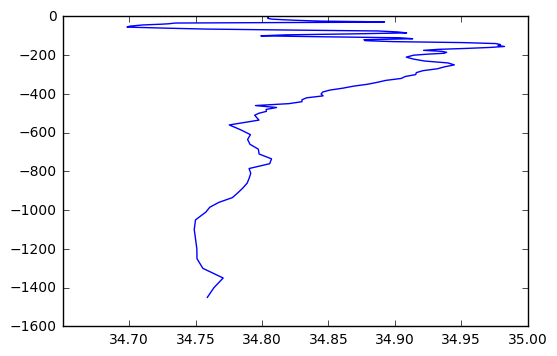

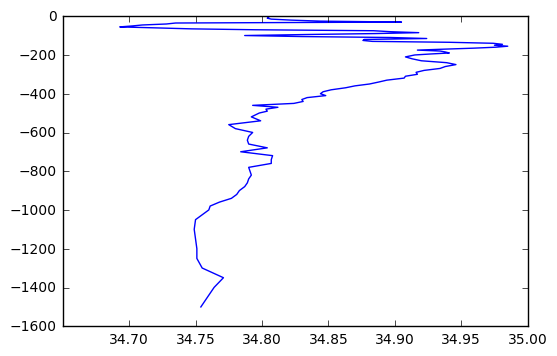

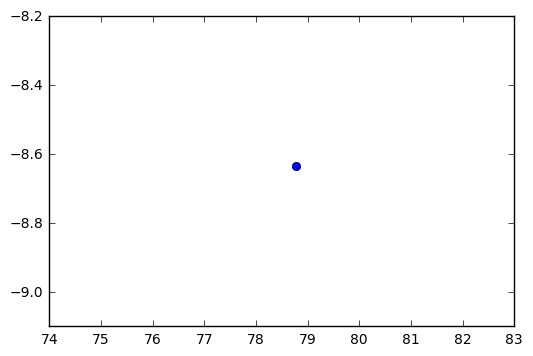

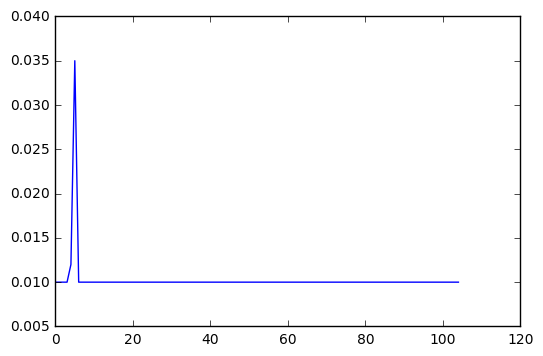

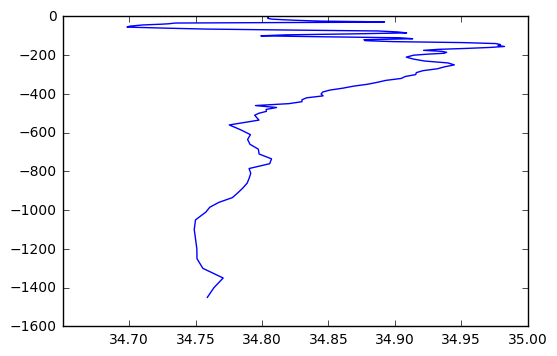

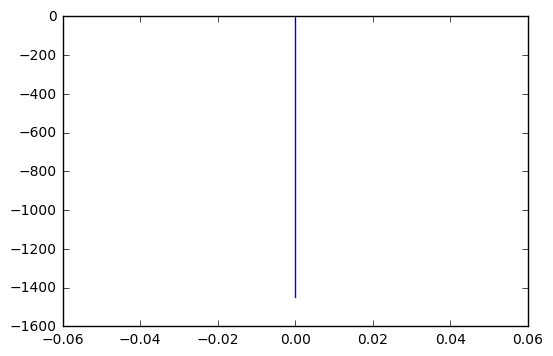

In [19]:
plt.figure()
#plt.plot(S[months==10].T, -pnew)
plt.plot(S[np.logical_and(years==2010, months==10)].T, -pnew)
plt.figure()
#for n in np.where(months==10)[0]:
for n in np.where(np.logical_and(years==2010, months==10))[0]:
    plt.plot(argo_profs[n][17], -argo_profs[n][12])
plt.figure()
for n in np.where(np.logical_and(years==2010, months==10))[0]:
    plt.plot(lons[n], lats[n],'ob')
#plt.show()
len(S[np.logical_and(years==2010, months==10)])
plt.figure()
for n in np.where(np.logical_and(years==2010, months==10))[0]:
    #plt.plot(argo_profs[n][19], -argo_profs[n][12])
    plt.plot(argo_profs[n][19],)
    print n, argo_profs[n][18]
plt.figure()
plt.plot(S[np.logical_and(years==2010, months==10)].mean(axis=0), -pnew)
plt.figure()
plt.plot(S[np.logical_and(years==2010, months==10)].std(axis=0), -pnew)
print S[np.logical_and(years==2010, months==10)].std(axis=0).mean(), S[np.logical_and(years==2010, months==10)].std(axis=0).max()

In [ ]:
# this is was to debug something
#busca = np.where(months==10)[0]
#print busca
#print months[busca]
#plt.figure()
#plt.plot(argo_profs[busca[35]][15])
#plt.show()
#print argo_profs[busca[35]][15]
#print argo_profs[busca[35]][16]
#print argo_profs[busca[35]][17]
#print argo_profs[busca[35]][18]

2.40000009537 20.0
0.00999999977648 0.157647654414
0.00200000009499 0.00200000009499


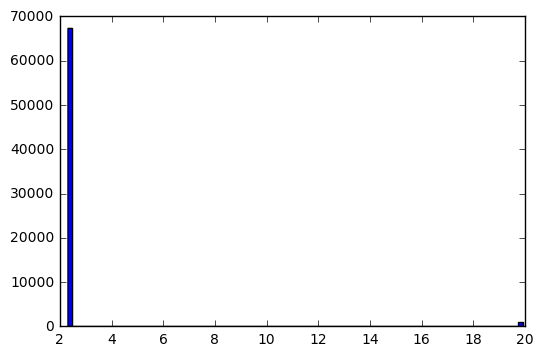

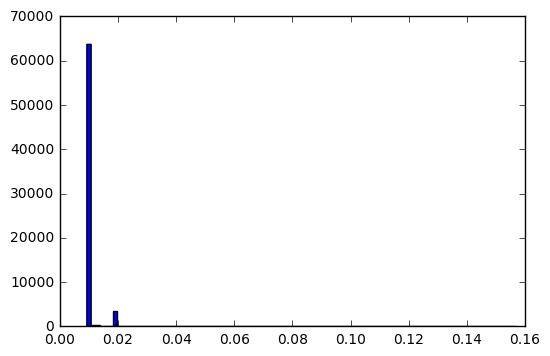

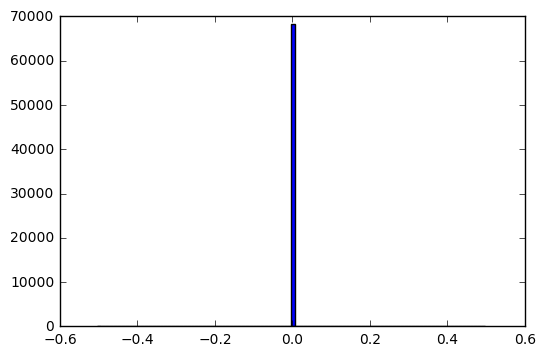

In [20]:
pres_err = zip(*argo_profs)[14]
sal_err = zip(*argo_profs)[19]
temp_err = zip(*argo_profs)[24]

Pe = [item for sublist in pres_err for item in sublist if item is not None or item is not nan]
Se = [item for sublist in sal_err for item in sublist if item is not None]
Te = [item for sublist in temp_err for item in sublist if item is not None]

Pe, Se, Te = np.asanyarray(Pe), np.asanyarray(Se), np.asanyarray(Te)
Pe, Se, Te = np.ma.masked_where(np.isnan(Pe), Pe), np.ma.masked_where(np.isnan(Se), Se), np.ma.masked_where(np.isnan(Te), Te)

plt.figure()
plt.hist(Pe.compressed(), bins=100, align="left")
print Pe.min(), Pe.max()
plt.figure()
plt.hist(Se.compressed(), bins=100, align="left")
print Se.min(), Se.max()
plt.figure()
plt.hist(Te.compressed(), bins=100, align="left")
print Te.min(), Te.max()

(-180, 0)

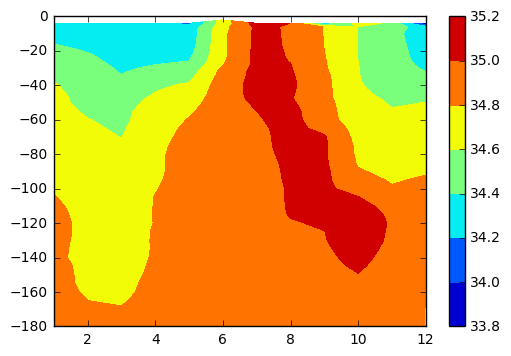

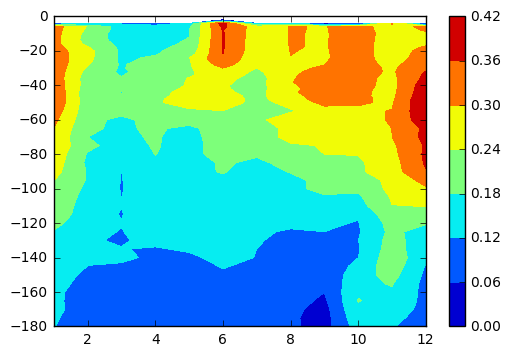

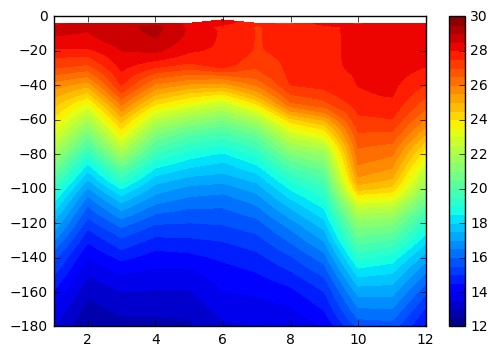

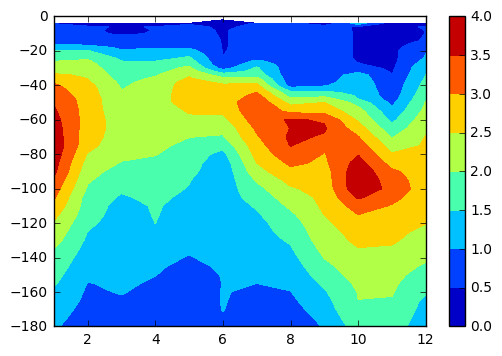

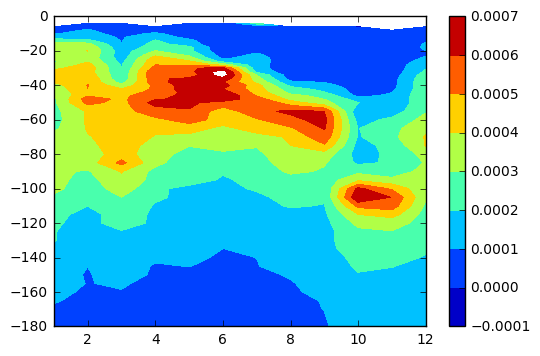

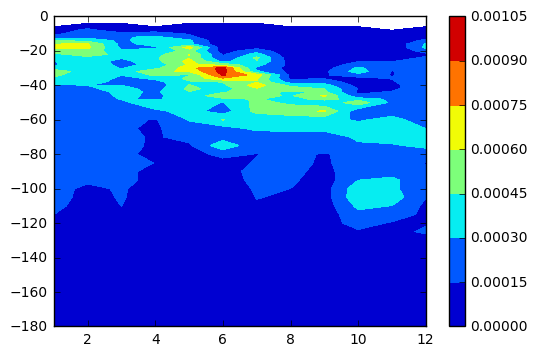

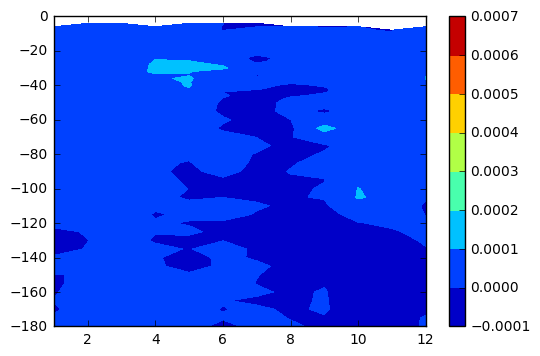

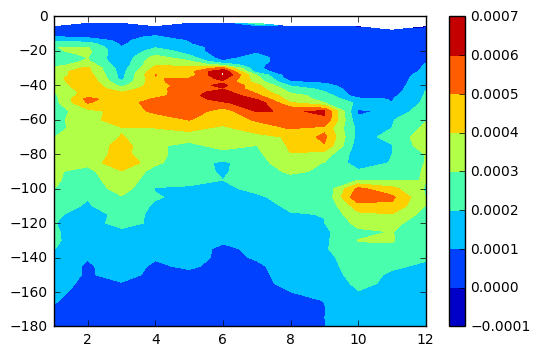

In [21]:
# lets plot a full seasonal composite using all years:
Sm = np.ma.empty((12, len(pnew)))
Sd = np.ma.empty((12, len(pnew)))
Tm = np.ma.empty((12, len(pnew)))
Td = np.ma.empty((12, len(pnew)))
Nsqm = np.ma.empty((12, len(pnew)))
Nsqd = np.ma.empty((12, len(pnew)))
Nsq_bm = np.ma.empty((12, len(pnew)))
Nsq_bd = np.ma.empty((12, len(pnew)))
Nsq_am = np.ma.empty((12, len(pnew)))
Nsq_ad = np.ma.empty((12, len(pnew)))
for m in range(len(set(months))):
    Sm[m] = S[months==m+1].mean(axis=0)
    Tm[m] = T[months==m+1].mean(axis=0)
    Sd[m] = S[months==m+1].std(axis=0)
    Td[m] = T[months==m+1].std(axis=0)
    Nsqm[m] = Nsq[months==m+1].mean(axis=0)
    Nsq_bm[m] = Nsq_beta[months==m+1].mean(axis=0)
    Nsq_am[m] = Nsq_alpha[months==m+1].mean(axis=0)
    Nsqd[m] = Nsq[months==m+1].std(axis=0)
    Nsq_bd[m] = Nsq_beta[months==m+1].std(axis=0)
    Nsq_ad[m] = Nsq_alpha[months==m+1].std(axis=0)

# need to make these figures prettier
plt.figure()
plt.contourf(np.unique(months), -pnew, Sm.T)
plt.colorbar()
plt.ylim([-180, 0])
plt.figure()
plt.contourf(np.unique(months), -pnew, Sd.T)
plt.colorbar()
plt.ylim([-180, 0])

plt.figure()
plt.contourf(np.unique(months), -pnew, Tm.T, levels=np.arange(12, 30.5, .5))
plt.colorbar()
plt.ylim([-180, 0])
plt.figure()
plt.contourf(np.unique(months), -pnew, Td.T)
plt.colorbar()
plt.ylim([-180, 0])

plt.figure()
plt.contourf(np.unique(months), -pnew, Nsqm.T, levels=np.arange(-1e-4, .8e-3, 1e-4))
plt.colorbar()
plt.ylim([-180, 0])
plt.figure()
plt.contourf(np.unique(months), -pnew, Nsqd.T)
plt.colorbar()
plt.ylim([-180, 0])

plt.figure()
plt.contourf(np.unique(months), -pnew, Nsq_bm.T, levels=np.arange(-1e-4, .8e-3, 1e-4))
plt.colorbar()
plt.ylim([-180, 0])

plt.figure()
plt.contourf(np.unique(months), -pnew, -Nsq_am.T, levels=np.arange(-1e-4, .8e-3, 1e-4))
plt.colorbar()
plt.ylim([-180, 0])

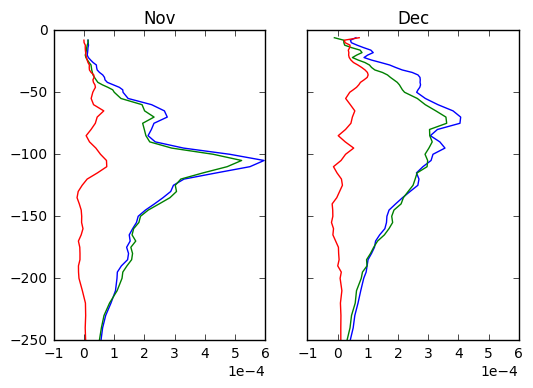

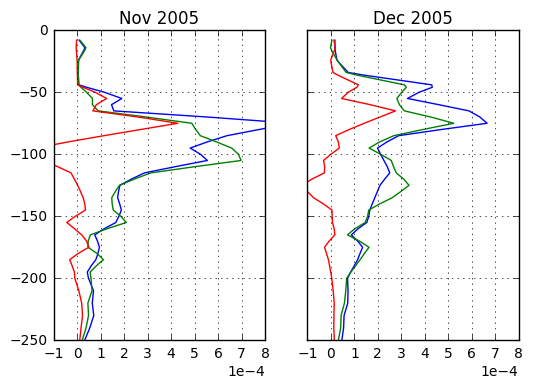

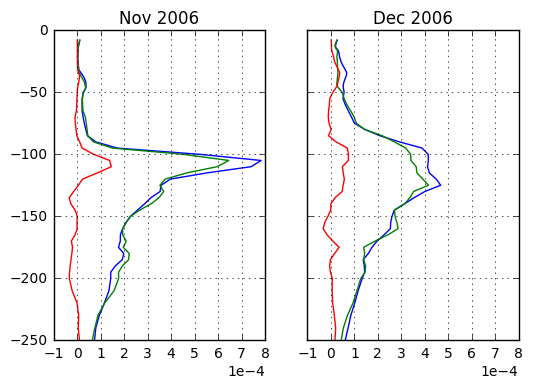

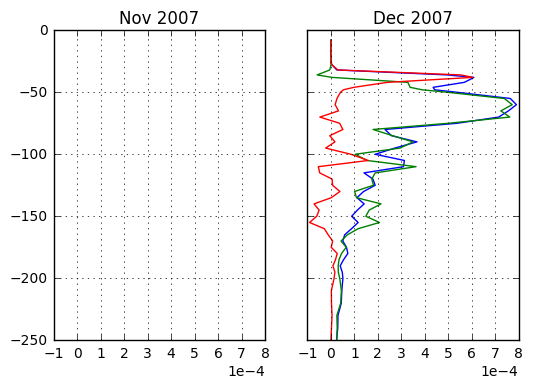

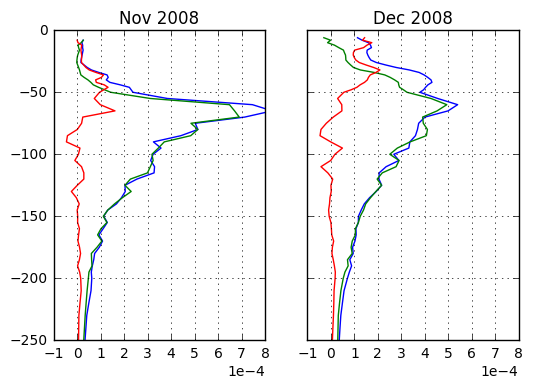

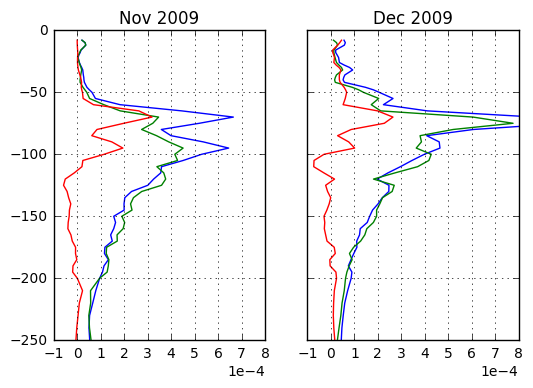

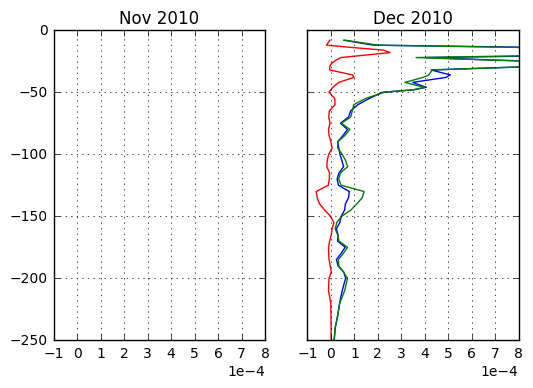

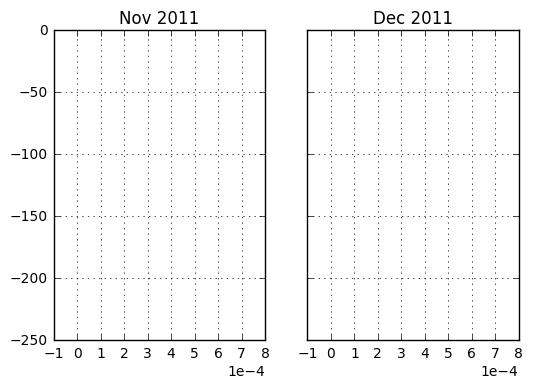

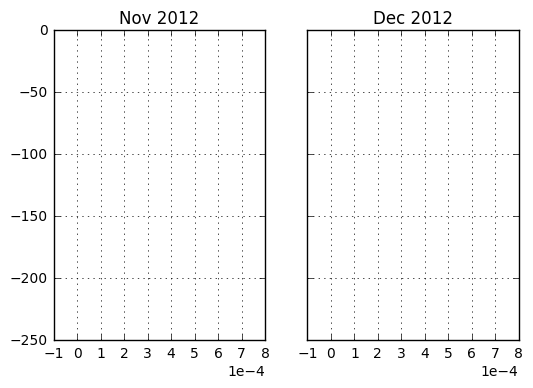

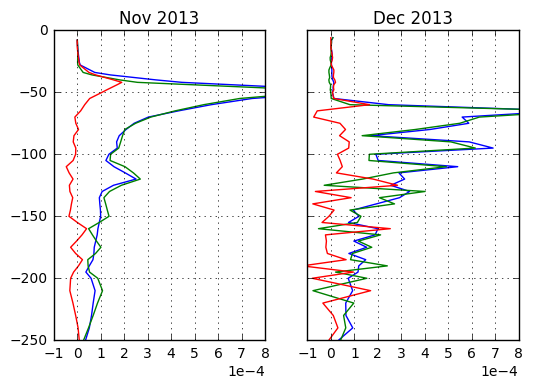

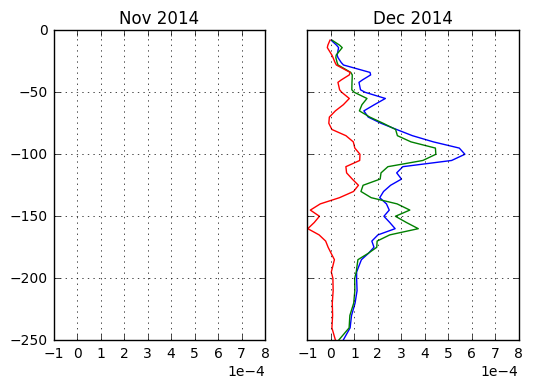

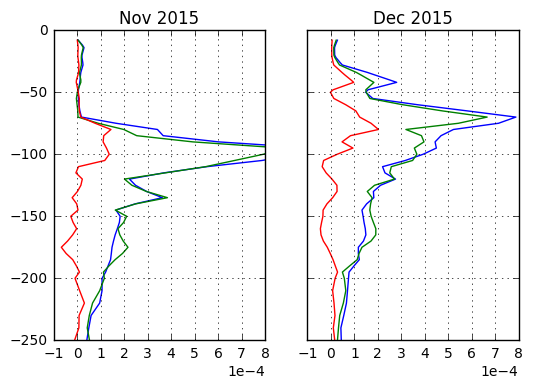

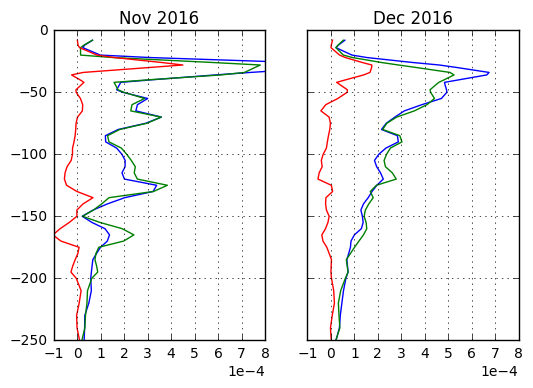

In [26]:
from matplotlib import ticker
# now same but selecting only IOD neutral years

# now some profiles from 2010, 2011 then 2016: compare those with appropriate means (focus on Dec)
#Sm = S[months==12].mean(axis=0)  # all year Dec mean
#Tm = T[months==12].mean(axis=0)  # all year Dec mean

Nsqm = Nsq[months==11].mean(axis=0)  # all year Nov mean
Nsq_bm = Nsq_beta[months==11].mean(axis=0)  # all year Nov mean
Nsq_am = Nsq_alpha[months==11].mean(axis=0)  # all year Nov mean

fig, AX = plt.subplots(1,2, sharex=True, sharey=True)
AX[0].plot(Nsqm, -pnew)
AX[0].plot(-Nsq_am, -pnew, Nsq_bm, -pnew,)
#AX[0].plot(Nsq_bm, -pnew)
AX[0].set_ylim([-250, 0])
AX[0].set_title("Nov")
#AX[0].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True,))
AX[0].xaxis.major.formatter.set_powerlimits((0,0)) 
AX[0].ticklabel_format(axis="x", style='sci', useMathText=True)

Nsqm = Nsq[months==12].mean(axis=0)  # all year Dec mean
Nsq_bm = Nsq_beta[months==12].mean(axis=0)  # all year Dec mean
Nsq_am = Nsq_alpha[months==12].mean(axis=0)  # all year Dec mean

AX[1].plot(Nsqm, -pnew)
AX[1].plot(-Nsq_am, -pnew)
AX[1].plot(Nsq_bm, -pnew)
AX[1].set_ylim([-250, 0])
AX[1].set_title("Dec")

dayears = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
for y in dayears:
    Nsqm = Nsq[np.logical_and(months==11, years==y)].mean(axis=0)  # all year Nov mean
    Nsq_bm = Nsq_beta[np.logical_and(months==11, years==y)].mean(axis=0)  # all year Nov mean
    Nsq_am = Nsq_alpha[np.logical_and(months==11, years==y)].mean(axis=0)  # all year Nov mean
    fig, AX = plt.subplots(1,2, sharex=True, sharey=True)
    AX[0].plot(Nsqm, -pnew, -Nsq_am, -pnew, Nsq_bm, -pnew)
    AX[0].set_ylim([-250, 0])
    AX[0].grid()
    AX[0].set_xlim([-1e-4, .8e-3])
    AX[0].set_title("Nov " + str(y))
    AX[0].xaxis.major.formatter.set_powerlimits((0,0)) 
    AX[0].ticklabel_format(axis="x", style='sci', useMathText=True)
    Nsqm = Nsq[np.logical_and(months==12, years==y)].mean(axis=0)  # all year Dec mean
    Nsq_bm = Nsq_beta[np.logical_and(months==12, years==y)].mean(axis=0)  # all year Dec mean
    Nsq_am = Nsq_alpha[np.logical_and(months==12, years==y)].mean(axis=0)  # all year Dec mean
    AX[1].plot(Nsqm, -pnew, -Nsq_am, -pnew, Nsq_bm, -pnew)
    AX[1].grid()
    AX[1].set_title("Dec " + str(y))


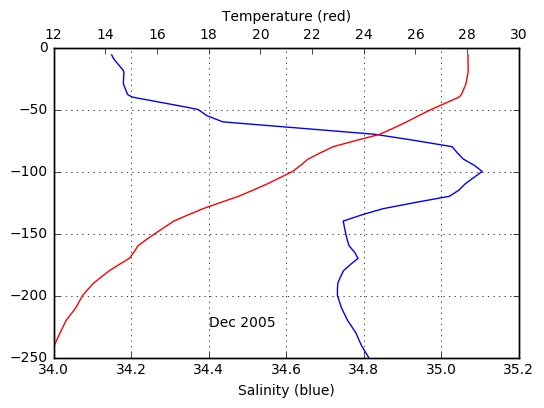

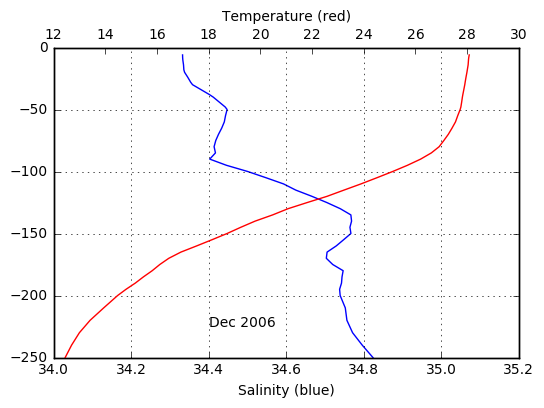

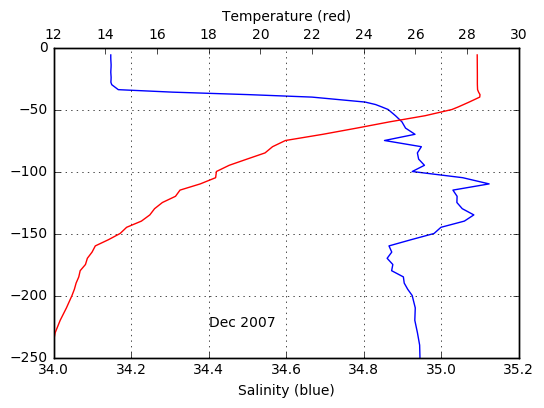

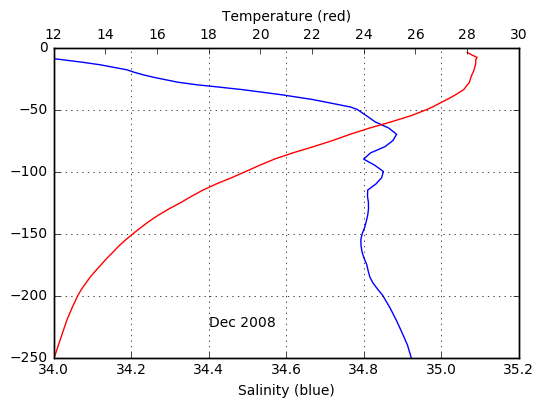

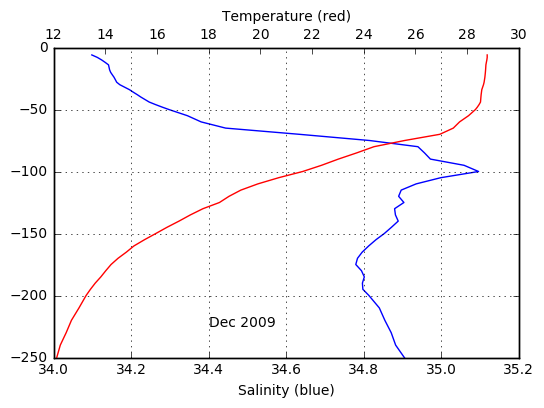

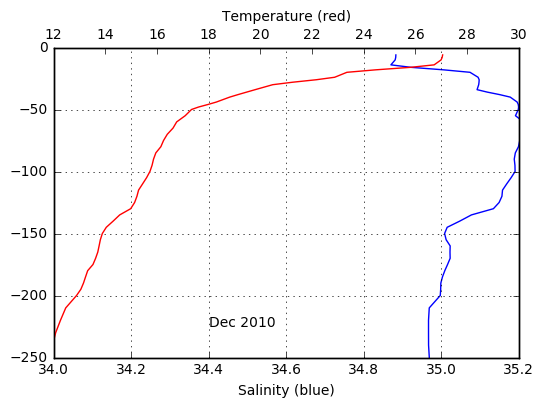

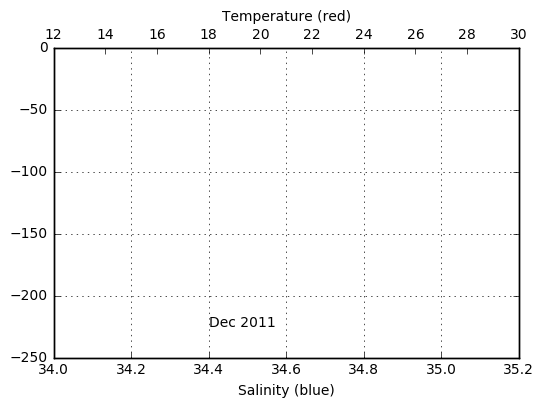

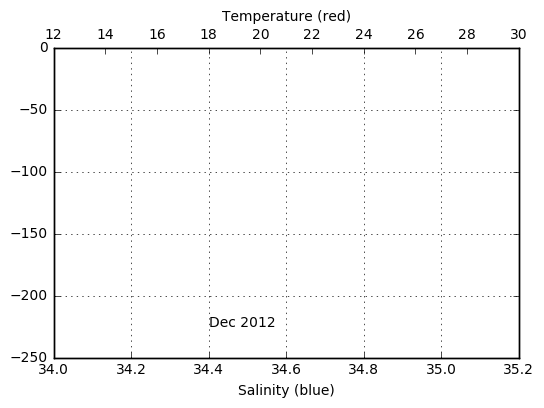

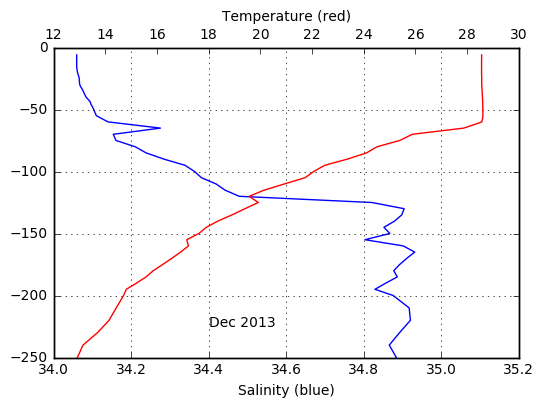

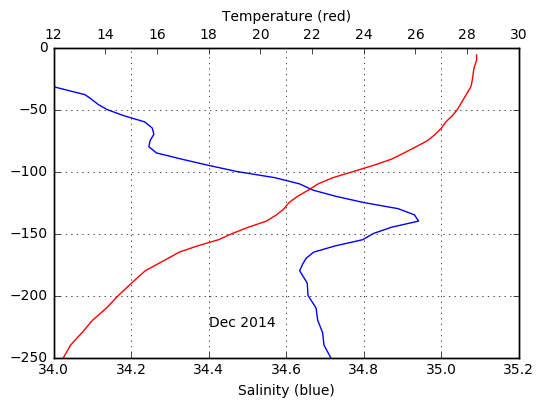

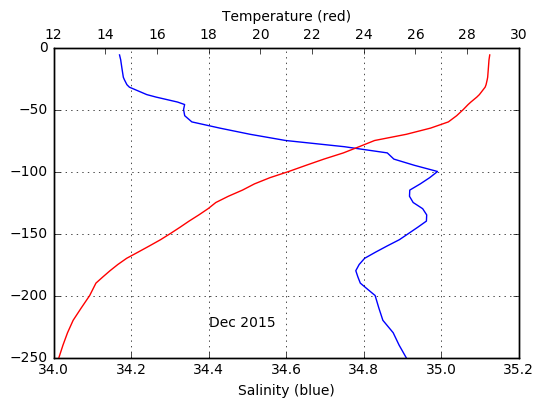

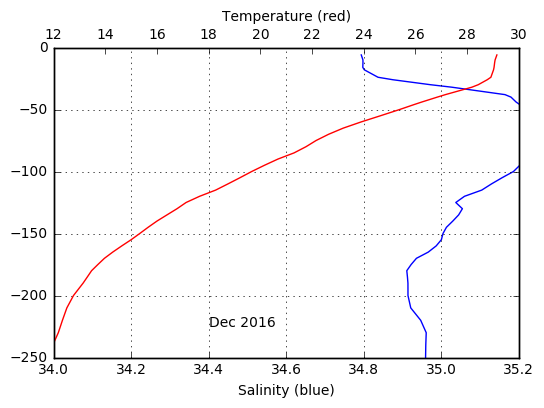

In [31]:
dayears = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
for y in dayears:
    Sm = S[np.logical_and(months==12, years==y)].mean(axis=0)  # all year Dec mean
    Tm = T[np.logical_and(months==12, years==y)].mean(axis=0)  # all year Dec mean
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(Sm, -pnew)
    ax2 = ax.twiny()
    ax2.plot(Tm, -pnew, 'r')
    #plt.plot(-Nsq_am, -pnew)
    #plt.plot(Nsq_bm, -pnew)
    ax.set_ylim([-250, 0])
    ax.grid()
    ax.set_xlim([34, 35.2])
    ax2.set_xlim([12, 30])
    ax.text(34.4, -225, "Dec " + str(y))
    ax.set_xlabel("Salinity (blue)")
    ax2.set_xlabel("Temperature (red)")
